In [1]:
import os
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from monai.networks.schedulers import DDPMScheduler
from monai.inferers.inferer import DiffusionInferer
from torch.optim.lr_scheduler import MultiStepLR
import pandas as pd
from monai.bundle import ConfigParser
import nibabel as nib
from torch.utils.data import Dataset

#%% Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [2]:
# Setup paths to uploaded training data
training_dataset = 'TrainingData_Key/slices_40_new_anon-20250703T131958Z-1-001'

In [3]:
# Setup paths to uploaded config files
config_path_ = 'Configs/configs'

In [4]:
pretrained_path = 'trained_vAE_epoch_148.pt'

In [5]:
def create_datasets(df, data_dir):

    df['Linked_Files_Anon'] = df['Linked_Files_Anon'].apply(lambda x: os.path.join(data_dir, x))

    train_data = df[df['Set']=='Train']
    valid_data = df[df['Set']=='Validation']
    test_data = df[df['Set']=='Test']

    train_data = train_data.reset_index()
    valid_data = valid_data.reset_index()
    test_data = test_data.reset_index()

    train_dataset = FDG_Dataset(data=train_data)
    valid_dataset = FDG_Dataset(data=valid_data)
    test_dataset = FDG_Dataset(data=test_data)

    return train_dataset, valid_dataset, test_dataset

In [6]:
class FDG_Dataset(Dataset):
    """
    A PyTorch Dataset to load NIfTI files from a provided list of file paths.
    """
    def __init__(self, data):
        """
        Args:
            file_paths (list of Path objects): List of paths to the NIfTI files.
        """

        self.csv = data

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        diag = self.csv.loc[idx, 'DX_encoded']
        file_name = self.csv.loc[idx, 'Linked_Files_Anon']

        nii_img  = nib.load(file_name)
        nii_data = nii_img.get_fdata()

        nii_data_scaled = (nii_data - nii_data.min())/(nii_data.max() - nii_data.min())
        image_tensor = torch.from_numpy(nii_data_scaled)

        return image_tensor, diag

In [7]:
# Config filename
config_file="train_autoencoder.json"

# Weights Filename
weights_file="trained_vAE_epoch_76.pt"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Setup weights filepath
weights_path = os.path.join(pretrained_path, weights_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
vAE_model = config.get_parsed_content("gnetwork")

# Load checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# Key remapping
key_mapping = {
    "encoder.blocks.10.to_q.weight": "encoder.blocks.10.attn.to_q.weight",
    "encoder.blocks.10.to_q.bias": "encoder.blocks.10.attn.to_q.bias",
    "encoder.blocks.10.to_k.weight": "encoder.blocks.10.attn.to_k.weight",
    "encoder.blocks.10.to_k.bias": "encoder.blocks.10.attn.to_k.bias",
    "encoder.blocks.10.to_v.weight": "encoder.blocks.10.attn.to_v.weight",
    "encoder.blocks.10.to_v.bias": "encoder.blocks.10.attn.to_v.bias",
    "encoder.blocks.10.proj_attn.weight": "encoder.blocks.10.attn.out_proj.weight",
    "encoder.blocks.10.proj_attn.bias": "encoder.blocks.10.attn.out_proj.bias",
    "decoder.blocks.2.to_q.weight": "decoder.blocks.2.attn.to_q.weight",
    "decoder.blocks.2.to_q.bias": "decoder.blocks.2.attn.to_q.bias",
    "decoder.blocks.2.to_k.weight": "decoder.blocks.2.attn.to_k.weight",
    "decoder.blocks.2.to_k.bias": "decoder.blocks.2.attn.to_k.bias",
    "decoder.blocks.2.to_v.weight": "decoder.blocks.2.attn.to_v.weight",
    "decoder.blocks.2.to_v.bias": "decoder.blocks.2.attn.to_v.bias",
    "decoder.blocks.2.proj_attn.weight": "decoder.blocks.2.attn.out_proj.weight",
    "decoder.blocks.2.proj_attn.bias": "decoder.blocks.2.attn.out_proj.bias",
    "decoder.blocks.6.conv.conv.weight": "decoder.blocks.6.postconv.conv.weight",
    "decoder.blocks.6.conv.conv.bias": "decoder.blocks.6.postconv.conv.bias",
    "decoder.blocks.9.conv.conv.weight": "decoder.blocks.9.postconv.conv.weight",
    "decoder.blocks.9.conv.conv.bias": "decoder.blocks.9.postconv.conv.bias",
}

# Remap keys
new_state_dict = {key_mapping.get(k, k): v for k, v in checkpoint.items()}

# Load state
vAE_model.load_state_dict(new_state_dict, strict=False)
vAE_model.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): AEKLDownsample(
        (pad): AsymmetricPad()
        (conv): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4): AEKLResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
  

In [8]:
# Load config file
config_file="train_cond_diffusion.json"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
LDM_model = config.get_parsed_content("diffusion").to(device)

In [9]:
# Datasets / Dataloader
data = os.path.join('TrainingData_Key/data_key_anon.csv')
data = pd.read_csv(data)
train_dataset, valid_dataset, test_dataset = create_datasets(data, training_dataset)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

# Epochs
training_epochs = 500

# Learning rate
init_lr = 5e-05
fin_lr = 1e-08
# Optimizer
optimiser = optim.Adam(LDM_model.parameters(), lr=init_lr)
# Learning rate scheduler
#lr_scheduler = CombinedScheduler(optimiser, 1, training_epochs, 20, init_lr, fin_lr)

# LDM Scheduler
ldm_scheduler = DDPMScheduler(schedule="scaled_linear_beta", num_train_timesteps=1000, beta_start=0.0015, beta_end= 0.0195)

# Inferer
inferer = DiffusionInferer(ldm_scheduler)

# Output folder
output_folder = '/content/output'

In [10]:
LDM_state_dict = torch.load('Checkpoints_conditioned/trained_LDM_epoch_96.pt', mmap=True, weights_only=True)
LDM_model.load_state_dict(LDM_state_dict, assign=True)
LDM_model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Diffus

In [19]:
import time
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

save_dir = "./synthetic_non_conditional"
os.makedirs(save_dir, exist_ok=True)

vAE_model.eval()
LDM_model.eval()

np_imgs = np.zeros([1, 1, 240, 240])

list_diag = [torch.tensor(0.0), torch.tensor(0.5), torch.tensor(1.0)]

for k in range(3):
    for i in range(10):
        with torch.no_grad():
            noise = torch.randn((64, 1, 64, 64))
            noise = noise.to(device)
            ldm_scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                diagnosis = list_diag[k]
                diag = diagnosis.unsqueeze(dim=-1)
                diag = diag.unsqueeze(dim=-1)
                diag = diag.unsqueeze(dim=-1).to(device)
                image = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler, mode="crossattn", conditioning=diag)
                image = image[:, :, 2:-2, 2:-2]
                image = vAE_model.decode(image).cpu().detach().numpy()
                np_imgs = np.concatenate((np_imgs, image), axis=0)

fake_images = np_imgs[1:]
print(np.shape(fake_images))

/tmp/ipykernel_1519821/1551047899.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.34it/s]


(1920, 1, 240, 240)


In [27]:
import pandas as pd

data_dir = 'TrainingData_Key/slices_40_new_anon-20250703T131958Z-1-001/'
df = pd.read_csv('TrainingData_Key/data_key_anon.csv')

np_imgs = np.zeros([1,1,240,240])

df['Linked_Files_Anon'] = df['Linked_Files_Anon'].apply(lambda x: os.path.join(data_dir, x))

diags = [0.0, 0.5, 1.0]

for i in range(3):
    current_diag = diags[i]
    current_df = df[df['DX_encoded']==current_diag]
    for idx, row in current_df.iterrows():
        file_name = row['Linked_Files_Anon']
        nii_img = nib.load(file_name)
        real_images = nii_img.get_fdata()
        real_images = (real_images - np.min(real_images))/(np.max(real_images) - np.min(real_images))
        np_imgs = np.concatenate((np_imgs, np.expand_dims(np.expand_dims(real_images, axis=0), axis=0)), axis=0)

real_images = np_imgs[1:]
print(np.shape(real_images))

(1338, 1, 240, 240)


In [22]:
np.shape(fake_images)

(1920, 1, 240, 240)

In [35]:
from torchmetrics.image.fid import FrechetInceptionDistance

size_ls = [0, 342, 342 + 594, 342 + 594 + 326]

for i in range(3):
    fid = FrechetInceptionDistance(normalize=True)
    fid.update(torch.tensor(real_images[size_ls[1]:size_ls[2]]).repeat(1,3,1,1), real=True)
    fid.update(torch.tensor(fake_images[i*640:(i+1)*640]).repeat(1,3,1,1), real=False)
    print(f"FID: {float(fid.compute())}")

FID: 81.29517364501953
FID: 79.91686248779297
FID: 78.17215728759766


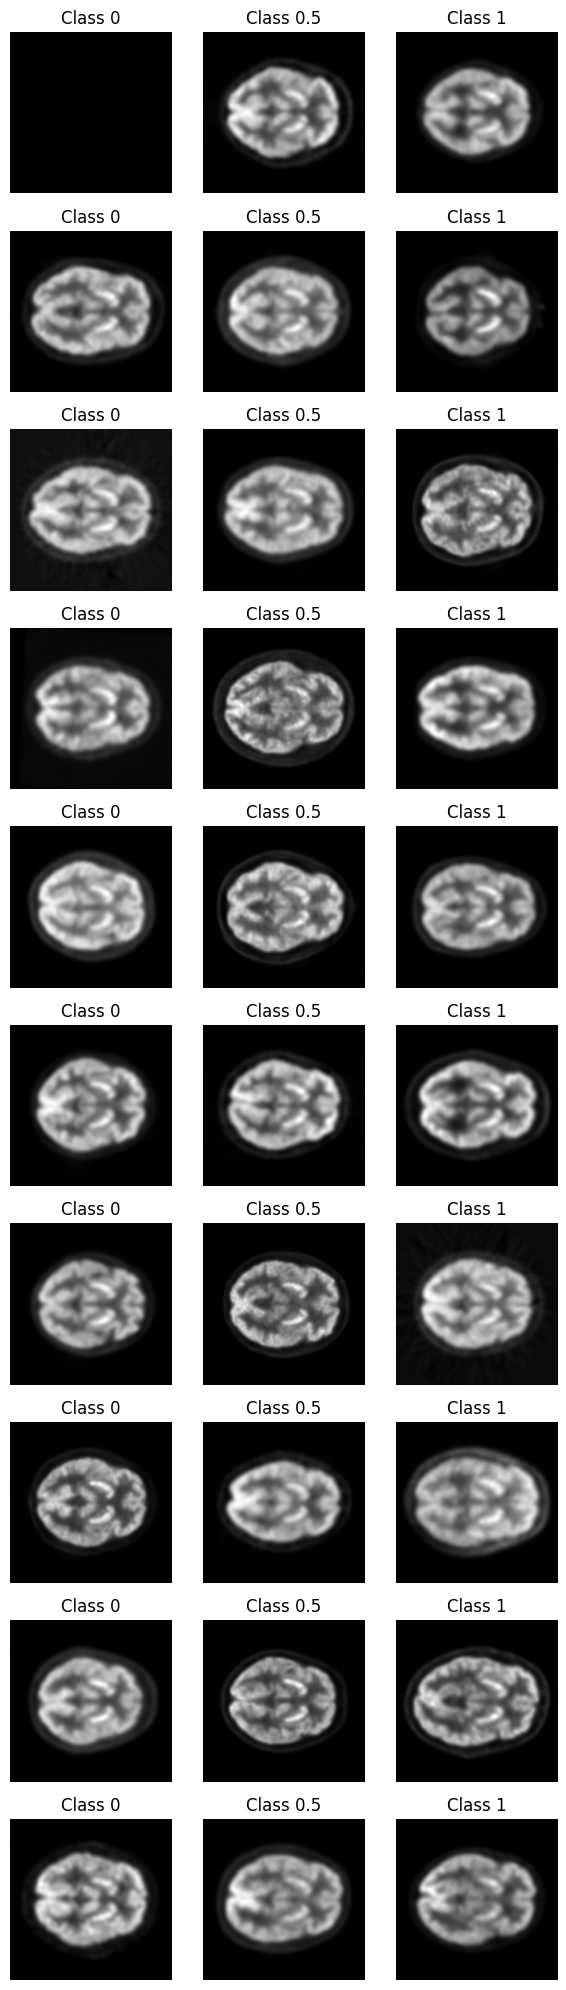

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assume np_imgs has shape [N, 1, H, W] or [N, H, W]
# If it's [N, 1, H, W], squeeze the channel dimension for plotting
if np_imgs.ndim == 4 and np_imgs.shape[1] == 1:
    np_imgs_plot = np_imgs.squeeze(1)
else:
    np_imgs_plot = np_imgs

size_ls = [0, 342, 936, 1262]
indices_class_0 = np.arange(size_ls[0], size_ls[1])
indices_class_05 = np.arange(size_ls[1], size_ls[2])
indices_class_1 = np.arange(size_ls[2], size_ls[3])

# Randomly select 10 from each class (or just the first 10)
num_rows = 10
sel_0 = indices_class_0[:num_rows]
sel_05 = indices_class_05[:num_rows]
sel_1 = indices_class_1[:num_rows]

fig, axs = plt.subplots(num_rows, 3, figsize=(6, 20))

for i in range(num_rows):
    axs[i, 0].imshow(np_imgs_plot[sel_0[i]], cmap='gray')
    axs[i, 0].set_title('Class 0')
    axs[i, 1].imshow(np_imgs_plot[sel_05[i]], cmap='gray')
    axs[i, 1].set_title('Class 0.5')
    axs[i, 2].imshow(np_imgs_plot[sel_1[i]], cmap='gray')
    axs[i, 2].set_title('Class 1')

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(np.shape(fake_images))

In [33]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)
fid.update(torch.tensor(real_images).repeat(1,3,1,1), real=True)
fid.update(torch.tensor(fake_images).repeat(1,3,1,1), real=False)

print(f"FID: {float(fid.compute())}")

FID: 78.18346405029297
